In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import dill as pickle
import corner
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt

import torch
from sklearn.model_selection import train_test_split

os.chdir('/scratch/gpfs/jiaxuanl/Data/popsed/')
sys.path.append('/home/jiaxuanl/Research/popsed/')
from popsed.speculator import SuperSpeculator
import popsed
popsed.set_matplotlib(style='JL', usetex=True, dpi=80, fontsize=16)
from popsed import prior

In [3]:
name = 'NMF'
wave = np.load(f'./train_sed_{name}/{name.lower()}_seds/fsps.wavelength.npy')

if name == 'NMF_ZH':
    spec_dir = [
        f'./train_sed_{name}/best_emu/speculator_best_recon_model_{name}_{i_bin}.pkl' for i_bin in range(0, 5)]
    params_name = ['kappa1_sfh', 'kappa2_sfh', 'kappa3_sfh',
                   'fburst', 'tburst', 'gamma1_zh', 'gamma2_zh',
                   'dust1', 'dust2',
                   'dust_index', 'redshift', 'logm']
else:
    spec_dir = [
        f'./train_sed_{name}/best_emu/speculator_best_recon_model_{name}.emu_{i_bin}.pkl' for i_bin in range(0, 5)]
    params_name = ['kappa1_sfh', 'kappa2_sfh', 'kappa3_sfh',
                   'fburst', 'tburst', 'logzsol',
                   'dust1', 'dust2',
                   'dust_index', 'redshift', 'logm']
speculator = SuperSpeculator(
    speculators_dir=spec_dir,
    str_wbin=['.w1000_2000',
              '.w2000_3600',
              '.w3600_5500',
              '.w5500_7410',
              '.w7410_60000'],
    wavelength=wave,
    params_name=params_name,
    device='cuda', use_speclite=True)
gama_filters = ['sdss2010-{0}'.format(b) for b in 'ugriz']
speculator._calc_transmission(gama_filters)


PHOT = 'AUTO'
noise = 'gama_snr'
# noise_model_dir = f'./noise_model/gama_snr_model_mag_dr3_apmatch_{PHOT}_snr1.npy'
noise_model_dir = f'./noise_model/gama_snr_model_mag_dr3_apmatch_{PHOT}.npy'

In [4]:
X_data = np.load(f'./reference_catalog/GAMA/gama_clean_mag_dr3_apmatch_{PHOT}_snr1.npy')[:, :5]
print('Total number of samples:', len(X_data))

Total number of samples: 83692


In [5]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [6]:
_prior_NDE = speculator.bounds.copy()

_prior_NDE[-2] = np.array([0., 0.8])
_prior_NDE[-1] = np.array([7.5, 13.])

In [7]:
nde_dir = './NDE/GAMA/anneal/real/lr3e-4_ann12_40e_snr20/'
temp = os.listdir(nde_dir)
filelist = [os.path.join(nde_dir, file) for file in temp if 'nde_theta_last' in file]

nde_dir = './NDE/GAMA/anneal/real/lr3e-4_ann8_40e_snr30/'
temp = os.listdir(nde_dir)
filelist += [os.path.join(nde_dir, file) for file in temp if 'nde_theta_last' in file]

nde_dir = './NDE/GAMA/anneal/real/lr3e-4_ann8_40e_snr30/'
temp = os.listdir(nde_dir)
filelist += [os.path.join(nde_dir, file) for file in temp if 'nde_theta_last' in file]

# ind = [int(file.replace(nde_dir, '').replace('nde_theta_last_model_nsf_', '').strip('.pkl')) for file in filelist]


# filelist = np.array(filelist)[(np.array(ind) > 30)]
# filelist = ['nde_theta_best_loss_nsf_20.pkl',
#             'nde_theta_best_loss_nsf_31.pkl',
#             'nde_theta_best_loss_nsf_25.pkl', 
#             'nde_theta_best_loss_nsf_35.pkl']

In [8]:
len(filelist)

30

In [9]:
# This is slow
NDE_list = []
for file in filelist[:]:
    try:
        NDE = pickle.load(open(file, 'rb'))
        del NDE.X
        del NDE.X_vali
        del NDE.batch_theta
#         NDE_list.append(NDE)
        if np.mean(NDE.vali_loss_history[-20:]) < 0.28 and np.mean(NDE.vali_loss_history[-20:]) > 0.2:
            NDE_list.append(NDE)
            pass
        else:
            print('Poor vali loss for', file)
            print('Remove', file)
    except Exception as e:
        print(file, e)
        continue

./NDE/GAMA/anneal/real/lr3e-4_ann12_40e_snr20/nde_theta_last_model_nsf_1.pkl Ran out of input
Poor vali loss for ./NDE/GAMA/anneal/real/lr3e-4_ann8_40e_snr30/nde_theta_last_model_nsf_25.pkl
Remove ./NDE/GAMA/anneal/real/lr3e-4_ann8_40e_snr30/nde_theta_last_model_nsf_25.pkl
Poor vali loss for ./NDE/GAMA/anneal/real/lr3e-4_ann8_40e_snr30/nde_theta_last_model_nsf_20.pkl
Remove ./NDE/GAMA/anneal/real/lr3e-4_ann8_40e_snr30/nde_theta_last_model_nsf_20.pkl
Poor vali loss for ./NDE/GAMA/anneal/real/lr3e-4_ann8_40e_snr30/nde_theta_last_model_nsf_29.pkl
Remove ./NDE/GAMA/anneal/real/lr3e-4_ann8_40e_snr30/nde_theta_last_model_nsf_29.pkl
Poor vali loss for ./NDE/GAMA/anneal/real/lr3e-4_ann8_40e_snr30/nde_theta_last_model_nsf_25.pkl
Remove ./NDE/GAMA/anneal/real/lr3e-4_ann8_40e_snr30/nde_theta_last_model_nsf_25.pkl
Poor vali loss for ./NDE/GAMA/anneal/real/lr3e-4_ann8_40e_snr30/nde_theta_last_model_nsf_20.pkl
Remove ./NDE/GAMA/anneal/real/lr3e-4_ann8_40e_snr30/nde_theta_last_model_nsf_20.pkl
Poor v

In [10]:
len(NDE_list)

23

In [11]:
### score for each model is vali_loss

In [12]:
vali_loss = np.array([np.mean(NDE.vali_loss_history[-20:]) for NDE in NDE_list])
vali_loss

array([0.25208516, 0.25670876, 0.26050553, 0.24788395, 0.26052217,
       0.2548056 , 0.25805549, 0.25310781, 0.25825976, 0.23629841,
       0.24425787, 0.23557716, 0.23941261, 0.23812636, 0.24167479,
       0.25273146, 0.23629841, 0.24425787, 0.23557716, 0.23941261,
       0.23812636, 0.24167479, 0.25273146])

In [13]:
vali_loss.mean(), np.std(vali_loss)

(0.24687354658608848, 0.008680572625751904)

In [14]:
score = np.min(vali_loss) / vali_loss
score

array([0.93451419, 0.91768257, 0.9043077 , 0.95035259, 0.90424993,
       0.92453682, 0.9128934 , 0.93073841, 0.91217135, 0.99694769,
       0.96446087, 1.        , 0.98397972, 0.98929475, 0.97476926,
       0.93212438, 0.99694769, 0.96446087, 1.        , 0.98397972,
       0.98929475, 0.97476926, 0.93212438])

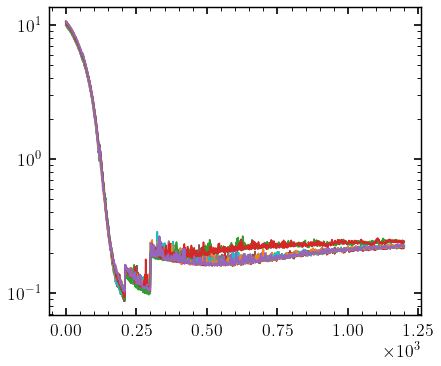

In [15]:
[plt.plot(NDE.train_loss_history) for NDE in np.array(NDE_list)[np.argsort(vali_loss)][:15]]
plt.yscale('log')

In [16]:
torch.cuda.empty_cache()

### Show each NDE

In [17]:
from popsed.nde import transform_nmf_params, inverse_transform_nmf_params

from popsed.nde import inverse_transform_nmf_params_given_mass

In [18]:
_samples_unt = []
_samples = []
for NDE in [NDE_list[i] for i in np.argsort(vali_loss)[:]]:
    _samp = inverse_transform_nmf_params(NDE.sample(2000), _prior_NDE).cpu().detach().numpy()
    
    _samples_unt.append(_samp)
    _samples.append(np.hstack([_samp[:, -1:], 
                   prior.FlatDirichletPrior(4).transform(_samp[:, :3]), 
                   _samp[:, 3:-1]]))
_samples_unt = np.dstack(_samples_unt)
_samples = np.dstack(_samples)

In [19]:
_spl = _samples_unt.swapaxes(0, 1).reshape(_samples_unt.shape[1], -1).T

In [20]:
import corner

In [21]:
z_mass_met = np.load(f'./reference_catalog/GAMA/gama_clean_z_mass_dr3_apmatch_{PHOT}_snr1.npy')

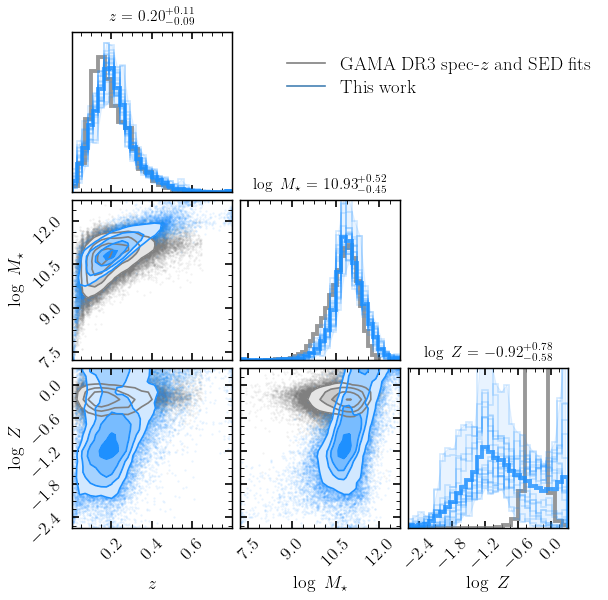

In [22]:
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='gray', label='GAMA DR3 spec-$z$ and SED fits')
b_line = mlines.Line2D([], [], color='steelblue', label=r'This work')

figure = corner.corner(z_mass_met, 
#                        fig=figure,
                  labels=['$z$', '$\log\ M_\star$', '$\log\ Z$'], bins=30,
                  color='gray', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.5, fill_contours=True,
                       range=[[0, 1], [8, 12], [-3, 1]], 
                  show_titles=True, title_kwargs={"fontsize": 14}, 
                        hist_kwargs={'density': True}, plot_datapoints=True)

figure = corner.corner(np.hstack([_samples_unt[:, -2:-1], _samples_unt[:, -1:] - 0.3, _samples_unt[:, 5:6]]), 
                       fig=figure,
                  labels=['$z$', '$\log\ M_\star$', '$\log\ Z$'], bins=30,
                  color='dodgerblue', # quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.5, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 14}, 
                        hist_kwargs={'density': True}, plot_datapoints=True)

ax = figure.get_axes()[2]
ax.legend(handles=[k_line, b_line], fontsize=17, bbox_to_anchor=(0., 1.0, 1.3, .0))

# plt.suptitle('GAMA DR3 aperture-matched photometry, SDSS $ugriz$', y=1.06)

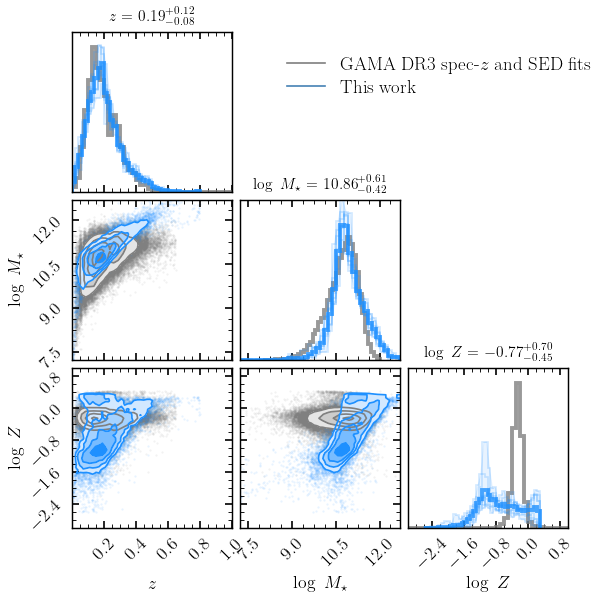

In [27]:
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='gray', label='GAMA DR3 spec-$z$ and SED fits')
b_line = mlines.Line2D([], [], color='steelblue', label=r'This work')

figure = corner.corner(z_mass_met, 
#                        fig=figure,
                  labels=['$z$', '$\log\ M_\star$', '$\log\ Z$'], bins=40,
                  color='gray', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.5, fill_contours=True,
                       range=[[0, 1], [8, 12], [-3, 1]], 
                  show_titles=True, title_kwargs={"fontsize": 14}, 
                        hist_kwargs={'density': True}, plot_datapoints=True)

figure = corner.corner(np.hstack([_samples_unt[:, -2:-1], _samples_unt[:, -1:]-0.3, _samples_unt[:, 5:6]]), 
                       fig=figure,
                  labels=['$z$', '$\log\ M_\star$', '$\log\ Z$'], bins=40,
                  color='dodgerblue', # quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.5, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 14}, 
                        hist_kwargs={'density': True}, plot_datapoints=True)

ax = figure.get_axes()[2]
ax.legend(handles=[k_line, b_line], fontsize=17, bbox_to_anchor=(0., 1.0, 1.3, .0))

# plt.suptitle('GAMA DR3 aperture-matched photometry, SDSS $ugriz$', y=1.06)

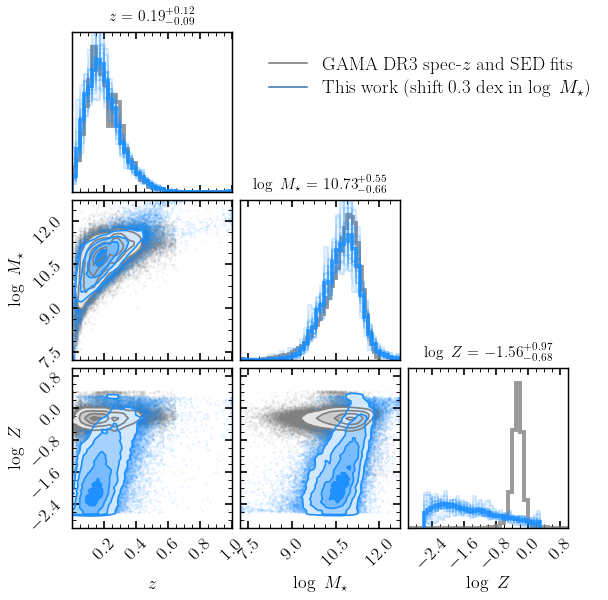

In [44]:
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='gray', label='GAMA DR3 spec-$z$ and SED fits')
b_line = mlines.Line2D([], [], color='steelblue', label=r'This work (shift 0.3 dex in $\log\ M_\star$)')

figure = corner.corner(z_mass_met, 
#                        fig=figure,
                  labels=['$z$', '$\log\ M_\star$', '$\log\ Z$'], bins=40,
                  color='gray', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.5, fill_contours=True,
                       range=[[0, 1], [8, 12], [-3, 1]], 
                  show_titles=True, title_kwargs={"fontsize": 14}, 
                        hist_kwargs={'density': True}, plot_datapoints=True)

figure = corner.corner(np.hstack([_samples_unt[:, -2:-1], _samples_unt[:, -1:] - 0.3, _samples_unt[:, 5:6]]), 
                       fig=figure,
                  labels=['$z$', '$\log\ M_\star$', '$\log\ Z$'], bins=40,
                  color='dodgerblue', # quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.5, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 14}, 
                        hist_kwargs={'density': True}, plot_datapoints=True)

ax = figure.get_axes()[2]
ax.legend(handles=[k_line, b_line], fontsize=17, bbox_to_anchor=(0., 1.0, 1.3, .0))

# plt.suptitle('GAMA DR3 aperture-matched photometry, SDSS $ugriz$', y=1.06)

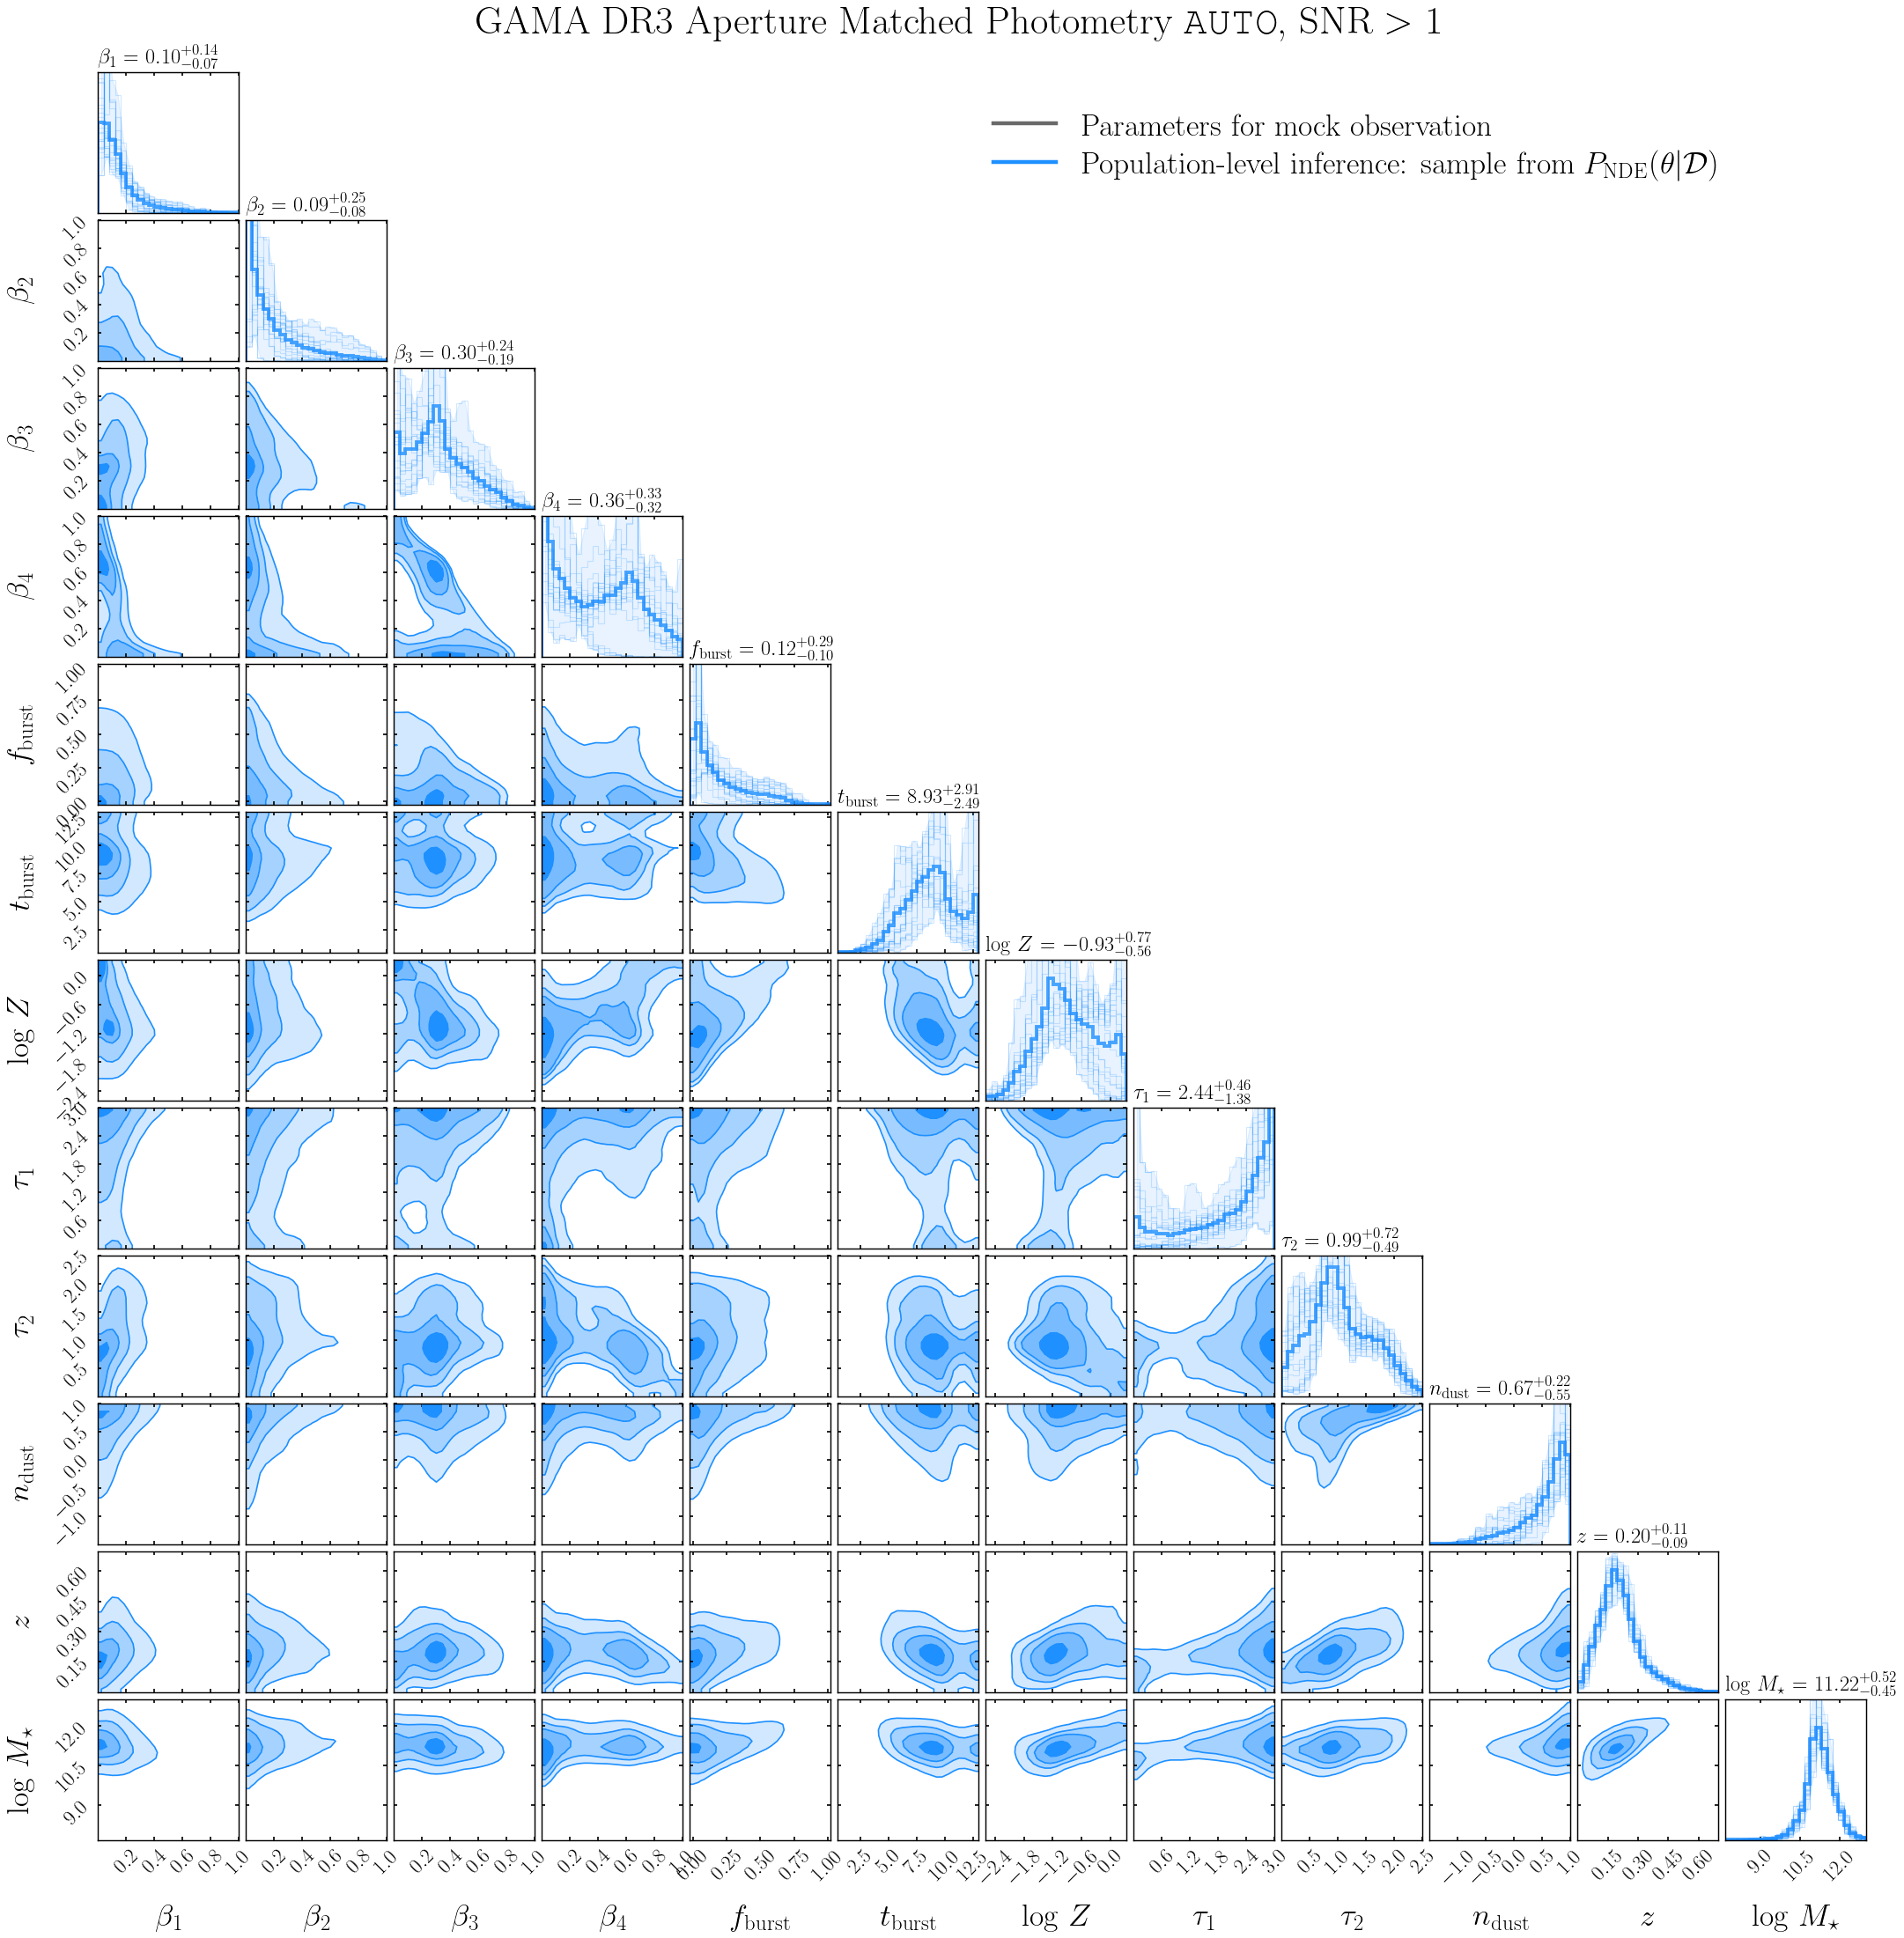

In [78]:
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], lw=4, color='dimgray', label='Parameters for mock observation')
b_line = mlines.Line2D([], [], color='dodgerblue', lw=4,
                       label=r'Population-level inference: sample from $P_{\mathrm{NDE}}(\theta|\mathcal{D})$')

labels = [
    r'$\beta_{1}$',
    r'$\beta_{2}$',
    r'$\beta_{3}$',
    r'$\beta_{4}$',
    r'$f_{\mathrm{burst}}$',
    r'$t_{\mathrm{burst}}$',
    r'$\log\,Z$',
    r'$\tau_1$',
    r'$\tau_2$',
    r'$n_{\mathrm{dust}}$',
    r'$z$',
    r'$\log\,M_{\star}$',
]

if name == 'NMF_ZH':
    labels = labels[:6] + [r'$\gamma_{1}$', r'$\gamma_{2}$'] + labels[7:]


y_truth_trans = np.hstack([_samples[:, 1:],  # params taken by emulator, including redshift (for t_age)
                           _samples[:, 0:1],  # stellar mass
                           ])
figure = corner.corner(
    y_truth_trans,
#     fig=figure,
    color='dodgerblue',
    labels=labels,
    range=[[0, 1], [0, 1], [0., 1], [0, 1], [-0.02, 1.02], [0.5, 13],
           [-2.6, 0.35], [0, 3], [0, 2.5], [-1.5, 1], [0, 0.7], [7.7, 13]],
    bins=25,
    smooth=1.0,
    fill_contours=True,
    show_titles=True,
    title_kwargs={'fontsize': 22, 'loc': 'left'},
    label_kwargs={'fontsize': 32},
    labelpad=0.15,
    hist_kwargs={'density': True, 'lw': 1},
    plot_datapoints=False
)

# ext_axes = np.array([[figure.get_axes()[12 * 11 - 2], figure.get_axes()[12 * 11 - 1]],
#                      [figure.get_axes()[12 * 12 - 2], figure.get_axes()[12 * 12 - 1]]])

# figure = corner.corner(
#     np.hstack([z_mass_met[:, 0:1], z_mass_met[:, 1:2] + 0.3]),
#     fig=figure,
#     ext_axes=ext_axes,
#     color='gray',
#     labels=None, #['$z$', '$\log\ M_\star$', '$\log\ Z$'], 
#     range=[[0, 0.7], [7.7, 13]],
#     bins=25,
#     smooth=1.0,
#     fill_contours=True,
#     show_titles=False,
#     title_kwargs={'fontsize': 22, 'loc': 'left'},
#     label_kwargs={'fontsize': 32},
#     labelpad=0.15,
#     hist_kwargs={'density': True, 'lw': 1},
#     plot_datapoints=False
# )
# ext_axes[1, 0].set_yticks([])

for ax in figure.get_axes():
    ax.tick_params(labelsize=21, length=4)
    ax.minorticks_off()

ax = figure.get_axes()[10]
leg = ax.legend(handles=[k_line, b_line],
          fontsize=32,
          bbox_to_anchor=(0., 1.0, 1.3, .0))

plt.suptitle(r'GAMA DR3 Aperture Matched Photometry $\texttt{AUTO}$, SNR $>$ 1', fontsize=40, y=1.02);
plt.show()
# plt.savefig('/tigress/jiaxuanl/public_html/figure/popsed/mock_test_posterior.pdf', 
#             bbox_inches='tight')

In [23]:
import popsed
popsed.set_matplotlib(style='JL', usetex=True, dpi=80, fontsize=25)

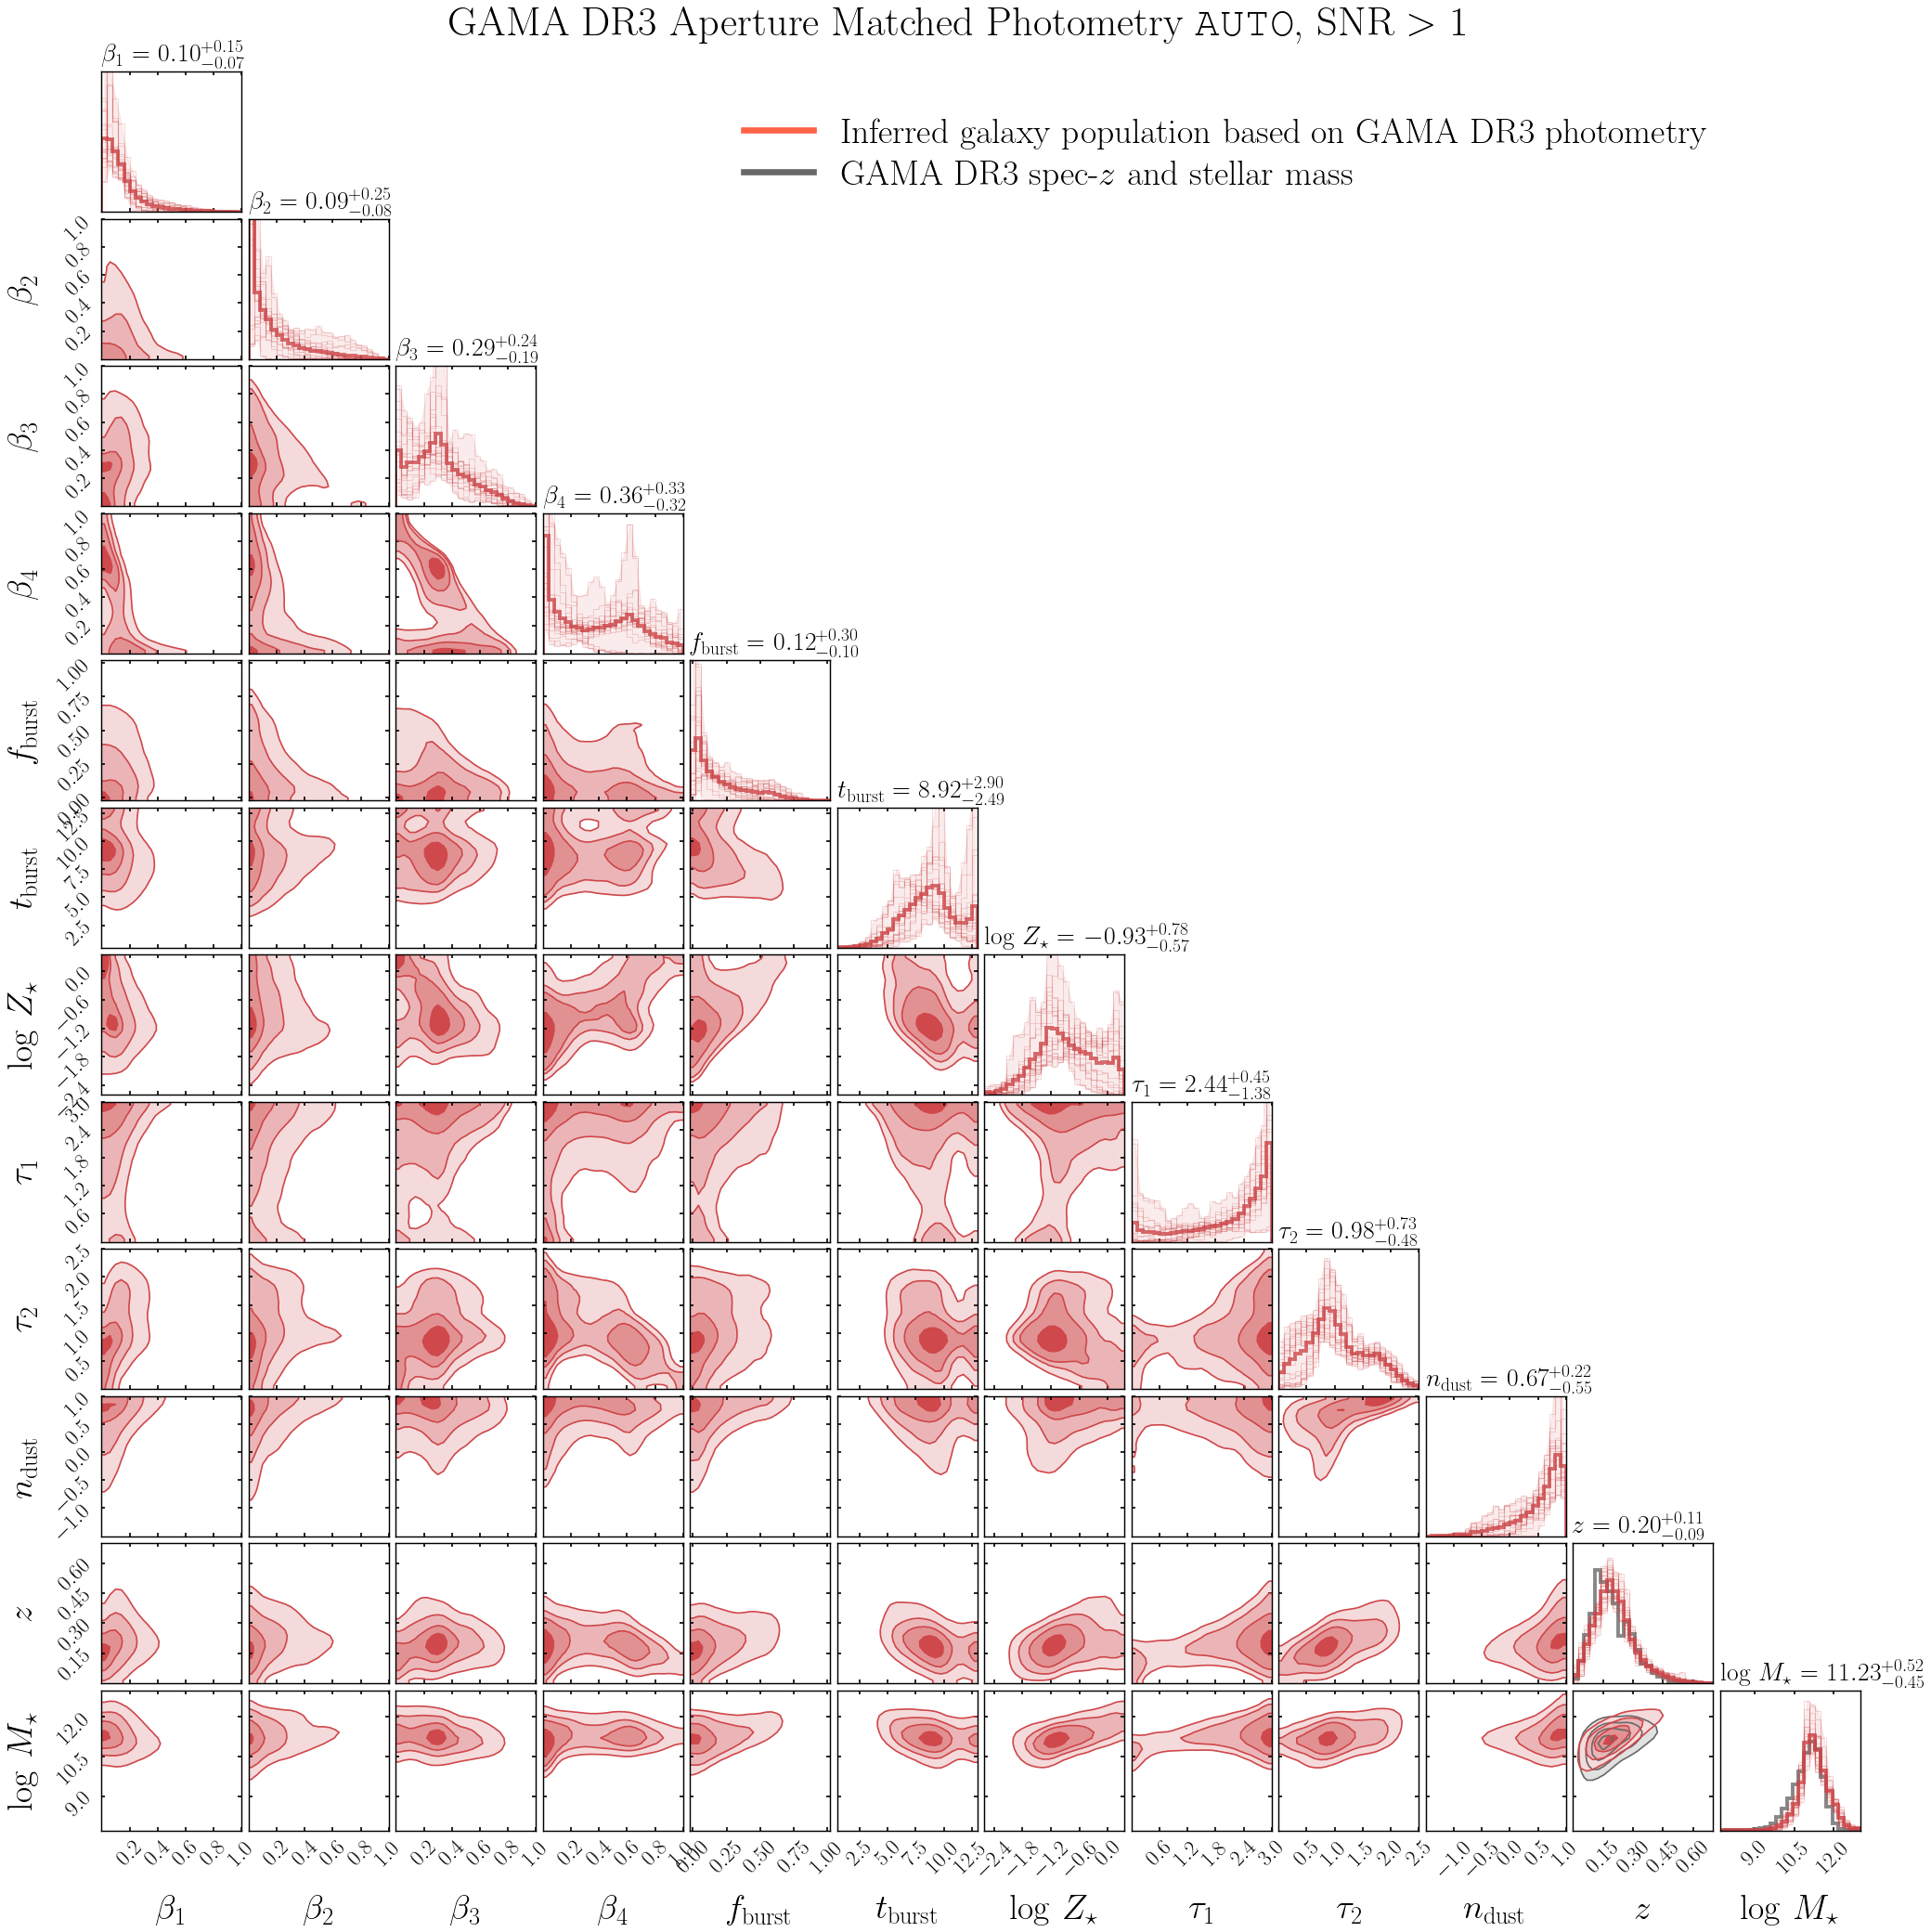

In [27]:
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], lw=6, color='dimgray', label='GAMA DR3 spec-$z$ and stellar mass')
b_line = mlines.Line2D([], [], color='tomato', lw=6,
                       label=r'Inferred galaxy population based on GAMA DR3 photometry')

labels = [
    r'$\beta_{1}$',
    r'$\beta_{2}$',
    r'$\beta_{3}$',
    r'$\beta_{4}$',
    r'$f_{\mathrm{burst}}$',
    r'$t_{\mathrm{burst}}$',
    r'$\log\,Z_\star$',
    r'$\tau_1$',
    r'$\tau_2$',
    r'$n_{\mathrm{dust}}$',
    r'$z$',
    r'$\log\,M_{\star}$',
]

if name == 'NMF_ZH':
    labels = labels[:6] + [r'$\gamma_{1}$', r'$\gamma_{2}$'] + labels[7:]


y_truth_trans = np.hstack([_samples[:, 1:],  # params taken by emulator, including redshift (for t_age)
                           _samples[:, 0:1],  # stellar mass
                           ])
K = y_truth_trans.shape[1]
figure, axes = plt.subplots(K, K, figsize=(25, 25))

ext_axes = np.array([[figure.get_axes()[12 * 11 - 2], figure.get_axes()[12 * 11 - 1]],
                     [figure.get_axes()[12 * 12 - 2], figure.get_axes()[12 * 12 - 1]]])

figure = corner.corner(
    np.hstack([z_mass_met[:, 0:1], z_mass_met[:, 1:2] + 0.3]),
    fig=figure,
    ext_axes=ext_axes,
    color='dimgray',
    labels=None, #['$z$', '$\log\ M_\star$', '$\log\ Z$'], 
    range=[[0, 0.7], [7.7, 13]],
    bins=25,
    smooth=1.0,
    fill_contours=True,
    show_titles=False,
    title_kwargs={'fontsize': 22, 'loc': 'left'},
    label_kwargs={'fontsize': 32},
    labelpad=0.15,
    hist_kwargs={'density': True, 'lw': 1},
    plot_datapoints=False
)
ext_axes[1, 0].set_yticks([])


figure = corner.corner(
    y_truth_trans,
    fig=figure,
    color='#cf484b',
    yfactor=1.25,
    labels=labels,
    range=[[0, 1], [0, 1], [0., 1], [0, 1], [-0.02, 1.02], [0.5, 13],
           [-2.6, 0.35], [0, 3], [0, 2.5], [-1.5, 1], [0, 0.7], [7.7, 13]],
    bins=25,
    smooth=1.0,
    fill_contours=True,
    show_titles=True,
    title_kwargs={'fontsize': 25, 'loc': 'left'},
    label_kwargs={'fontsize': 34},
    labelpad=0.15,
    hist_kwargs={'density': True, 'lw': 1},
    plot_datapoints=False
)


for ax in figure.get_axes():
    ax.tick_params(labelsize=21, length=4)
    ax.minorticks_off()

ax = figure.get_axes()[10]
leg = ax.legend(handles=[b_line, k_line],
          fontsize=34,
          bbox_to_anchor=(0., 1.0, 1.3, .0))

plt.suptitle(r'GAMA DR3 Aperture Matched Photometry $\texttt{AUTO}$, SNR $>$ 1', fontsize=40, y=1.02);
# plt.savefig('/tigress/jiaxuanl/public_html/figure/popsed/gama_dr3_snr1_posterior.pdf', 
#             bbox_inches='tight')

In [68]:
# del _samples
# import gc
# gc.collect()

In [161]:
noise, noise_model_dir

('gama_snr', './noise_model/gama_snr_model_mag_dr3_apmatch_AUTO.npy')

In [162]:
noise_model_dir = './noise_model/gama_snr_model_mag_dr3_apmatch_AUTO_snr1.npy'

0 20000
>30 0


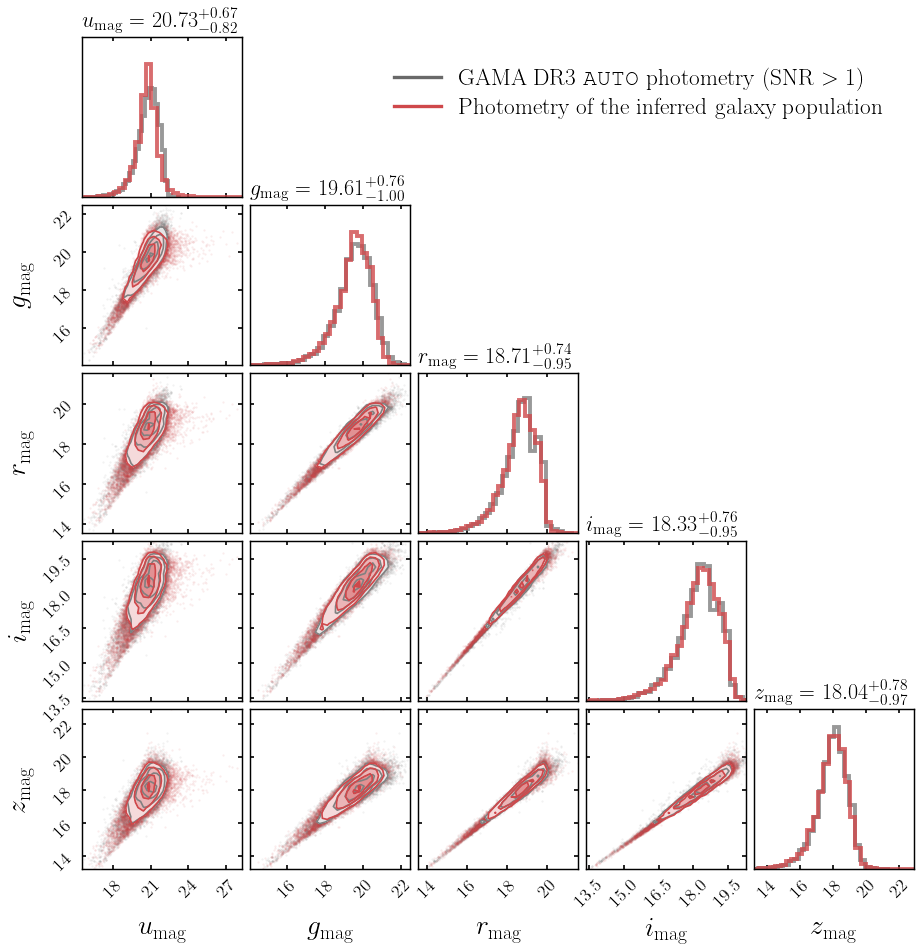

In [178]:
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], lw=3, color='dimgray', label=r'GAMA DR3 $\texttt{AUTO}$ photometry (SNR $> 1$)')
b_line = mlines.Line2D([], [], lw=3, color='#cf484b',
                       label=r'Photometry of the inferred galaxy population')

labels = [f'${filt}' + r'_{\rm mag}$' for filt in list('ugriz')]
#[filt.replace('_', '\_') for filt in gama_filters]

# Show mock data
figure = corner.corner(X_data[np.random.randint(0, len(X_data), 20000)],
                       color='gray', labels=labels, bins=30,
                       smooth=0.4, fill_contours=True,
                       show_titles=False,
                       title_kwargs={"fontsize": 20},
                       hist_kwargs={'density': True})

# Show posterior in magnitude space
_spl = _samples_unt.swapaxes(0, 1).reshape(_samples_unt.shape[1], -1).T
_spl = torch.Tensor(_spl[np.random.randint(0, len(_spl), 20000)]).to('cuda')

mags = speculator._predict_mag_with_mass_redshift(_spl,
                                                  filterset=gama_filters,
                                                  noise=noise,
                                                  noise_model_dir=noise_model_dir,
                                                  SNR=1,
                                                  ).cpu().detach().numpy()
print(np.isnan(mags).any(axis=1).sum(), len(mags))
print('>30', np.any(mags > 30, axis=1).sum())
mags = mags[~(np.isinf(mags).any(axis=1)| np.isnan(mags).any(axis=1))]
mags = mags[~np.any(mags > 30, axis=1)]
figure = corner.corner(mags,
                       fig=figure, labels=labels, bins=30,
                       color='#cf484b',
                       yfactor=1.2,
                       smooth=0.4, fill_contours=True,
                       show_titles=True,
                       title_kwargs={"fontsize": 20, 'loc': 'left'},
                       hist_kwargs={'density': True})

for ax in figure.get_axes():
    ax.tick_params(labelsize=16, length=4)
    ax.minorticks_off()
    
ax = figure.get_axes()[4]
leg = ax.legend(handles=[k_line, b_line],
                fontsize=21,)

plt.savefig('/tigress/jiaxuanl/public_html/figure/popsed/gama_dr3_snr1_photometry.pdf', 
            bbox_inches='tight')

---
### Calculate average age and SFR

In [24]:
from popsed.utils import calc_observables

In [25]:
obs_recs = []
for i in range(_samples.shape[2]): # 
    params = _samples[..., i]
    obs_recs.append(calc_observables(params, name, dt=0.1))

Initialize NMF-based SPS model
Input parameters : logmstar, beta1_sfh, beta2_sfh, beta3_sfh, beta4_sfh, fburst, tburst, logzsol, dust1, dust2, dust_index
Initialize NMF-based SPS model
Input parameters : logmstar, beta1_sfh, beta2_sfh, beta3_sfh, beta4_sfh, fburst, tburst, logzsol, dust1, dust2, dust_index
Initialize NMF-based SPS model
Input parameters : logmstar, beta1_sfh, beta2_sfh, beta3_sfh, beta4_sfh, fburst, tburst, logzsol, dust1, dust2, dust_index
Initialize NMF-based SPS model
Input parameters : logmstar, beta1_sfh, beta2_sfh, beta3_sfh, beta4_sfh, fburst, tburst, logzsol, dust1, dust2, dust_index
Initialize NMF-based SPS model
Input parameters : logmstar, beta1_sfh, beta2_sfh, beta3_sfh, beta4_sfh, fburst, tburst, logzsol, dust1, dust2, dust_index
Initialize NMF-based SPS model
Input parameters : logmstar, beta1_sfh, beta2_sfh, beta3_sfh, beta4_sfh, fburst, tburst, logzsol, dust1, dust2, dust_index
Initialize NMF-based SPS model
Input parameters : logmstar, beta1_sfh, beta2

In [26]:
obs_rec = {}
for k in obs_recs[0].keys():
    obs_rec[k] = np.array(tuple(d[k] for d in obs_recs))

In [27]:
obs_rec['logmstar'].shape

(23, 2000)

In [28]:
temp = np.hstack([obs_rec['logmstar'].T.reshape(2000, -1, _samples.shape[2]), 
                  obs_rec['redshift'].T.reshape(2000, -1, _samples.shape[2]),
                  np.log10(obs_rec['sfr'].T.reshape(2000, -1, _samples.shape[2])),
                  obs_rec['logzsol'].T.reshape(2000, -1, _samples.shape[2]),
                  obs_rec['age'].T.reshape(2000, -1, _samples.shape[2])])

In [44]:
flag = (obs_rec['redshift'] < 0.3)

Text(0, 0.5, 'SFR [Gyr$^{-1}$]')

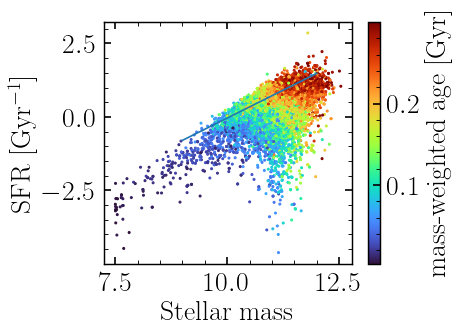

In [331]:
fig, ax = plt.subplots(figsize=(5, 4))

plt.scatter(obs_rec['logmstar'][flag], np.log10(obs_rec['sfr'][flag]), 
            c=obs_rec['redshift'][flag], s=3,)

x = np.linspace(9, 12)
# plt.plot(x, 0.84 * (x - 10.5) + 0.58)
plt.plot(x, 0.76 * (x) - 7.64)

# plt.xlim(9, 12.3)
# plt.ylim(-13, -8)

plt.colorbar(label='mass-weighted age [Gyr]')
plt.xlabel('Stellar mass')
plt.ylabel('SFR [Gyr$^{-1}$]')

Text(0, 0.5, 'SFR [Gyr$^{-1}$]')

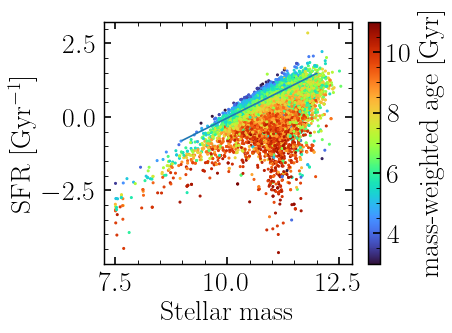

In [333]:
fig, ax = plt.subplots(figsize=(5, 4))

plt.scatter(obs_rec['logmstar'][flag], np.log10(obs_rec['sfr'][flag]), 
            c=obs_rec['age'][flag], s=3, vmin=3, vmax=11)

x = np.linspace(9, 12)
# plt.plot(x, 0.84 * (x - 10.5) + 0.58)
plt.plot(x, 0.76 * (x) - 7.64)

# plt.xlim(9, 12.3)
# plt.ylim(-13, -8)

plt.colorbar(label='mass-weighted age [Gyr]')
plt.xlabel('Stellar mass')
plt.ylabel('SFR [Gyr$^{-1}$]')

In [45]:
def speagle_MS(z, x):
    from astropy.cosmology import Planck15
    age = Planck15.age(z).value
    return (0.84 - 0.026 * age) * x - (6.51 - 0.11 * age)

In [46]:
import popsed
popsed.set_matplotlib(style='JL', usetex=True, dpi=80, fontsize=19)

In [47]:
flag = (obs_rec['redshift'] < 0.3)

Text(0, 0.5, 'SFR [$M_\\odot$ yr$^{-1}$]')

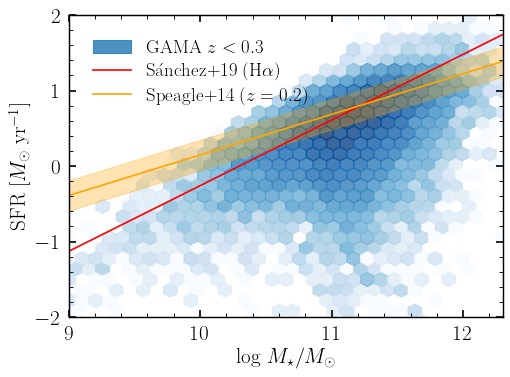

In [49]:
fig, ax = plt.subplots(figsize=(7, 5))

plt.hexbin(obs_rec['logmstar'][flag], np.log10(obs_rec['sfr'][flag]), 
           gridsize=50, cmap='Blues', bins='log', label=r'GAMA $z<0.3$', alpha=0.8)


# plt.scatter(obs_rec['logmstar'][flag], np.log10(obs_rec['sfr'][flag]), s=1, alpha=0.1)

x = np.linspace(9, 12.5)
plt.plot(x, 0.87 * (x) - 8.96, color='r', label=r'S\'anchez+19 (H$\alpha$)')

z = 0.17
plt.plot(x, speagle_MS(z, x), color='orange', alpha=1, label=r'Speagle+14 ($z=0.2$)')
plt.fill_between(x, speagle_MS(z, x) + 0.2, speagle_MS(z, x) - 0.2, color='orange', alpha=0.3)

plt.xlim(9, 12.3)
plt.ylim(-2, 2)

plt.legend(fontsize=17)
# plt.colorbar(label='mass-weighted age [Gyr]')
plt.xlabel(r'$\log\,M_\star/M_\odot$')
plt.ylabel('SFR [$M_\odot$ yr$^{-1}$]')

# plt.savefig('/tigress/jiaxuanl/public_html/figure/popsed/gama_dr3_sfms.pdf', 
#             bbox_inches='tight')

[11.8 11.8]


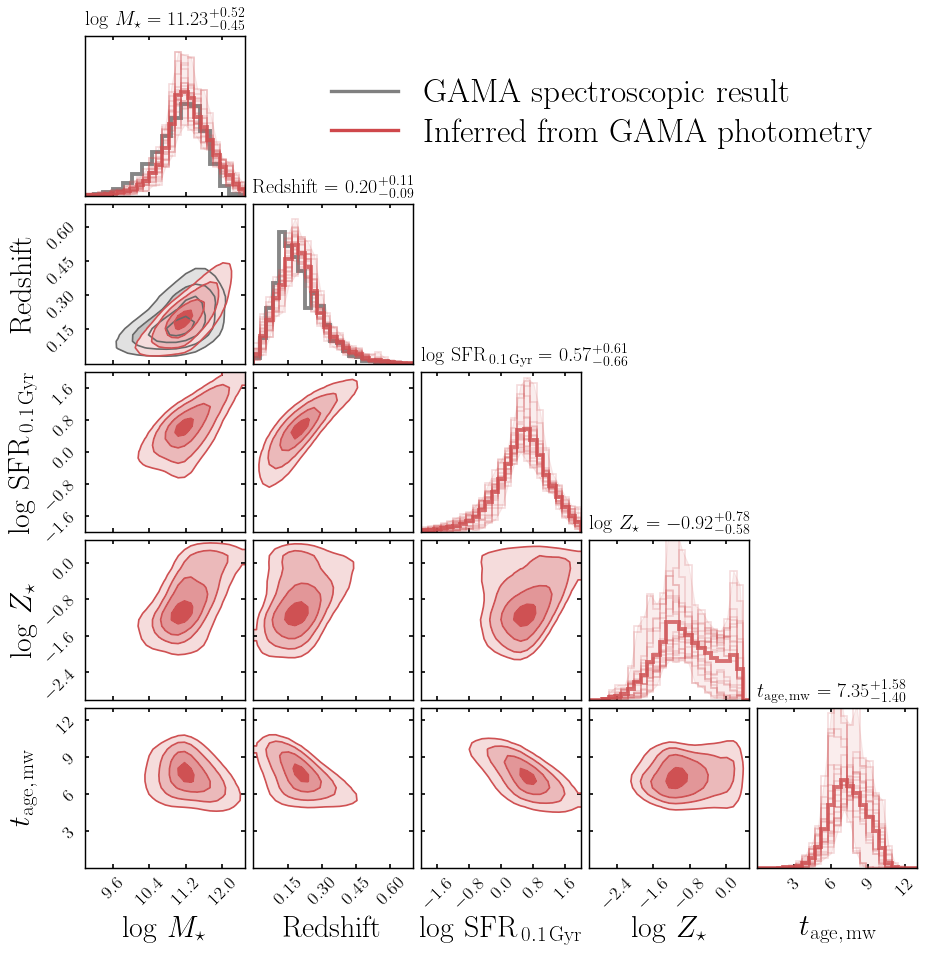

In [30]:
labels = [r'$\log\,M_{\star}$', r'Redshift', r'$\log\,\mathrm{SFR}_{\,0.1\,\rm Gyr}$', 
          r'$\log\,Z_{\star}$', r'$t_{\mathrm{age,\,mw}}$']

K = len(labels)
figure, axes = plt.subplots(K, K, figsize=(11.8, 11.8))

# ext_axes = np.array([[figure.get_axes()[K * (K-1) - 2], figure.get_axes()[K * (K-1) - 1]],
#                      [figure.get_axes()[K * K - 2], figure.get_axes()[K * K - 1]]])

ext_axes = np.array([[figure.get_axes()[0], figure.get_axes()[1]],
                     [figure.get_axes()[5], figure.get_axes()[6]]])

figure = corner.corner(
    np.hstack([z_mass_met[:, 1:2] + 0.35, z_mass_met[:, 0:1]]),
    fig=figure,
    ext_axes=ext_axes,
    color='dimgray',
    labels=None, #['$z$', '$\log\ M_\star$', '$\log\ Z$'], 
    range=[[7.7, 13], [0, 0.7]],
    bins=25,
    smooth=1.0,
    fill_contours=True,
    show_titles=False,
    title_kwargs={'fontsize': 22, 'loc': 'left'},
    label_kwargs={'fontsize': 32},
    labelpad=0.15,
    hist_kwargs={'density': True, 'lw': 1},
    plot_datapoints=False
)
ext_axes[1, 0].set_yticks([])

# np.vstack([obs_rec['logmstar'], obs_rec['redshift'],
# np.log10(obs_rec['sfr']), obs_rec['logzsol'], obs_rec['age']]).T,

figure = corner.corner(temp,
                       fig=figure,
                       yfactor=1.25,
                       labels=labels, 
                       bins=25, label_kwargs={'fontsize': 27},
                       color='#cf5153',  # quantiles=[0.16, 0.5, 0.84],
                       range=[[9, 12.5], [0, 0.7], [-2, 2], [-3, 0.5], [0, 13]],
                       smooth=1, fill_contours=True,
                       show_titles=True, title_kwargs={"fontsize": 18, 'loc': 'left'},
                       hist_kwargs={'density': True}, plot_datapoints=False)

import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='gray', lw=3, label='GAMA spectroscopic result')
b_line = mlines.Line2D([], [], color='#cf484b', lw=3,
                       label=r'Inferred from GAMA photometry')

for ax in figure.get_axes():
    ax.tick_params(labelsize=16, length=4)
    ax.minorticks_off()
    
ax = figure.get_axes()[4]
leg = ax.legend(handles=[k_line, b_line],
                fontsize=30,)

print(figure.get_size_inches())

plt.savefig('/tigress/jiaxuanl/public_html/figure/popsed/gama_params.pdf', 
            bbox_inches='tight',)

In [169]:
if name == 'NMF_ZH':
    from popsed.models import NMF_ZH
    model = NMF_ZH(burst=True, peraa=True)
else:
    from popsed.models import NMF
    model = NMF(burst=True, peraa=True)

Initialize NMF-based SPS model
Input parameters : logmstar, beta1_sfh, beta2_sfh, beta3_sfh, beta4_sfh, fburst, tburst, logzsol, dust1, dust2, dust_index


In [170]:
params = _samples.swapaxes(0, 1).reshape(_samples.shape[1], -1).T
params = torch.Tensor(params[np.random.randint(0, len(params), 5000)]).detach().cpu().numpy()

In [171]:
sfr = np.zeros(len(params))
age = np.zeros(len(params))

for i in range(len(params)):
    tt = params[i]
    sfr[i] = model.avgSFR(tt[:-1], zred=float(tt[-1]), dt=2)
    age[i] = model.tage_MW(tt[:-1], zred=float(tt[-1]))
    
if name == 'NMF_ZH':
    zmw = np.zeros(len(params))
    for i in range(len(params)):
        tt = params[i]
        zmw[i] = model.Z_MW(tt[:-1], zred=float(tt[-1]))
        
if name == 'NMF_ZH':
    logzsol = np.log10(zmw / 0.019)
else:
    logzsol = params[:, 7]
redshift = params[:, -1]

In [172]:
logmstar = params[:, 0]

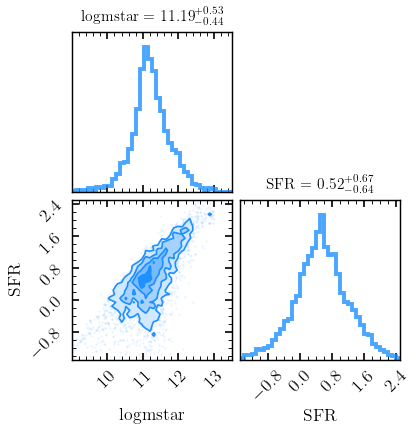

In [101]:
figure = corner.corner(np.vstack([logmstar, np.log10(sfr)]).T, 
                  labels=['logmstar', 'SFR'], bins=40,
                  color='dodgerblue', # quantiles=[0.16, 0.5, 0.84], 
                       range=[[9, 13.5], [-1.5, 2.5]],
                  smooth=0.3, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 14}, 
                        hist_kwargs={'density': True}, plot_datapoints=True)

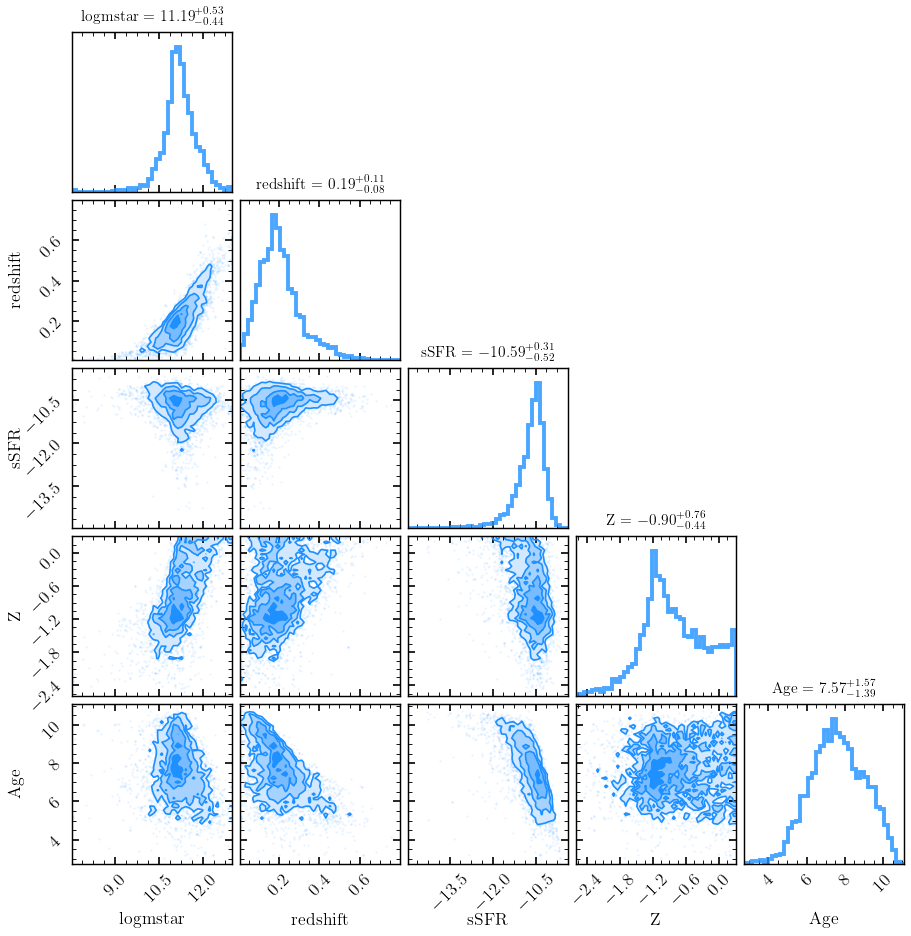

In [90]:
figure = corner.corner(np.vstack([logmstar, redshift, np.log10(sfr) - logmstar, logzsol, age]).T, 
                  labels=['logmstar', 'redshift', 'sSFR', 'Z', 'Age'], bins=40,
                  color='dodgerblue', # quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.3, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 14}, 
                        hist_kwargs={'density': True}, plot_datapoints=True)

In [94]:
# logmstar = _spl[:, 0].cpu().numpy()
# logzsol = _spl[:, 7].cpu().numpy()
# u_r = mags[:, 0] - mags[:, 2]

In [174]:
flag = (redshift > 0.)

Text(0, 0.5, 'SFR [Gyr$^{-1}$]')

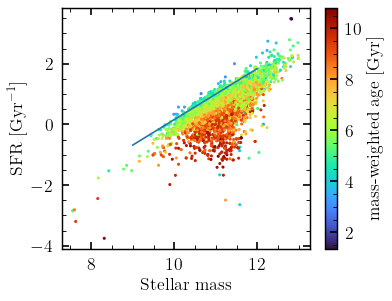

In [175]:
fig, ax = plt.subplots(figsize=(5, 4))

plt.scatter(logmstar[flag], np.log10(sfr)[flag], c=age[flag], s=3)

x = np.linspace(9, 12)
plt.plot(x, 0.84 * (x - 10.5) + 0.58)

# plt.xlim(9, 12.3)
# plt.ylim(-13, -8)

plt.colorbar(label='mass-weighted age [Gyr]')
plt.xlabel('Stellar mass')
plt.ylabel('SFR [Gyr$^{-1}$]')

Text(0, 0.5, 'Age [Gyr]')

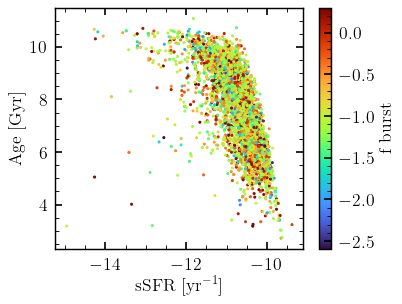

In [105]:
fig, ax = plt.subplots(figsize=(5, 4))

plt.scatter(np.log10(sfr) - logmstar, age, c=_spl[:, 5].cpu().numpy(), s=3)

# plt.xlim(9, 12.3)
# plt.ylim(-13, -8)

plt.colorbar(label='f burst')
plt.xlabel('sSFR [yr$^{-1}$]')
plt.ylabel('Age [Gyr]')

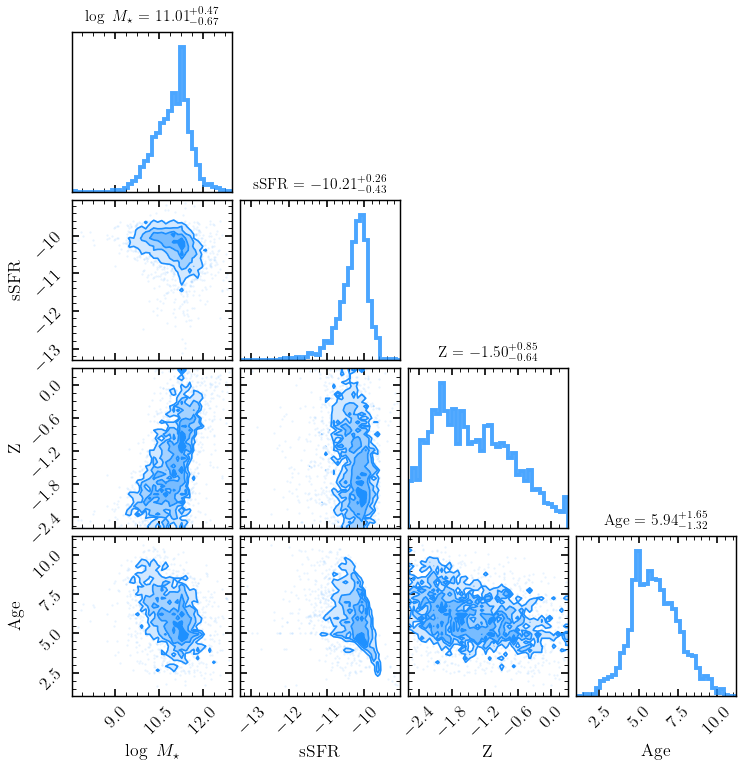

In [161]:
figure = corner.corner(np.vstack([logmstar, np.log10(sfr)-logmstar, logzsol, age]).T, 
                  labels=['$\log\ M_\star$', 'sSFR', 'Z', 'Age'], bins=40,
                  color='dodgerblue', # quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.3, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 14}, 
                        hist_kwargs={'density': True}, plot_datapoints=True)

# ax = figure.get_axes()[2]
# ax.legend(handles=[k_line, b_line], fontsize=17, bbox_to_anchor=(0., 1.0, 1.3, .0))

# plt.suptitle('GAMA DR3 aperture-matched photometry, SDSS $ugriz$', y=1.06)

In [29]:
tt = _samples[..., 0][0:1]
tage = model.cosmo.age(tt[:, -1:]).value # convert redshift to age
theta = model._parse_theta(tt[:, :-1])

Text(0, 0.5, 'SFR [Msun/yr] (normalized to 1 Msun)')

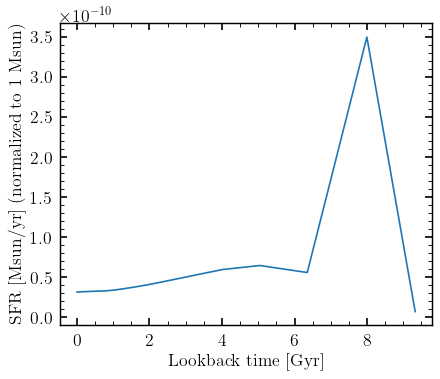

In [37]:
# Display SFH
tlb_edges, sfh = model.SFH(np.hstack([np.zeros(len(tt))[:, None], tt[:, 1:-1]]), zred=tt[:, -1][0], _burst=True)
plt.plot(0.5 * (tlb_edges[1:] + tlb_edges[:-1]), sfh)
plt.xlabel('Lookback time [Gyr]')
plt.ylabel('SFR [Msun/yr] (normalized to 1 Msun)')

In [73]:
sfrs = []
for tt in _samples[..., 0][0:1000]:
    sfrs.append(model.avgSFR(tt[:-1], zred=tt[-1], dt=1))
    
sfrs = np.array(sfrs).ravel()

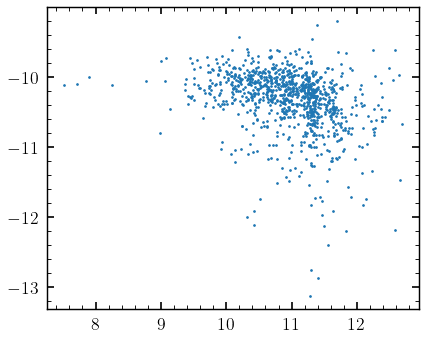

In [79]:
plt.scatter(_samples[..., 0][0:1000][:, 0], np.log10(sfrs) - _samples[..., 0][0:1000][:, 0], s=2)

In [80]:
model.tage_MW(tt[:-1], zred=tt[-1])

array([5.01615946])

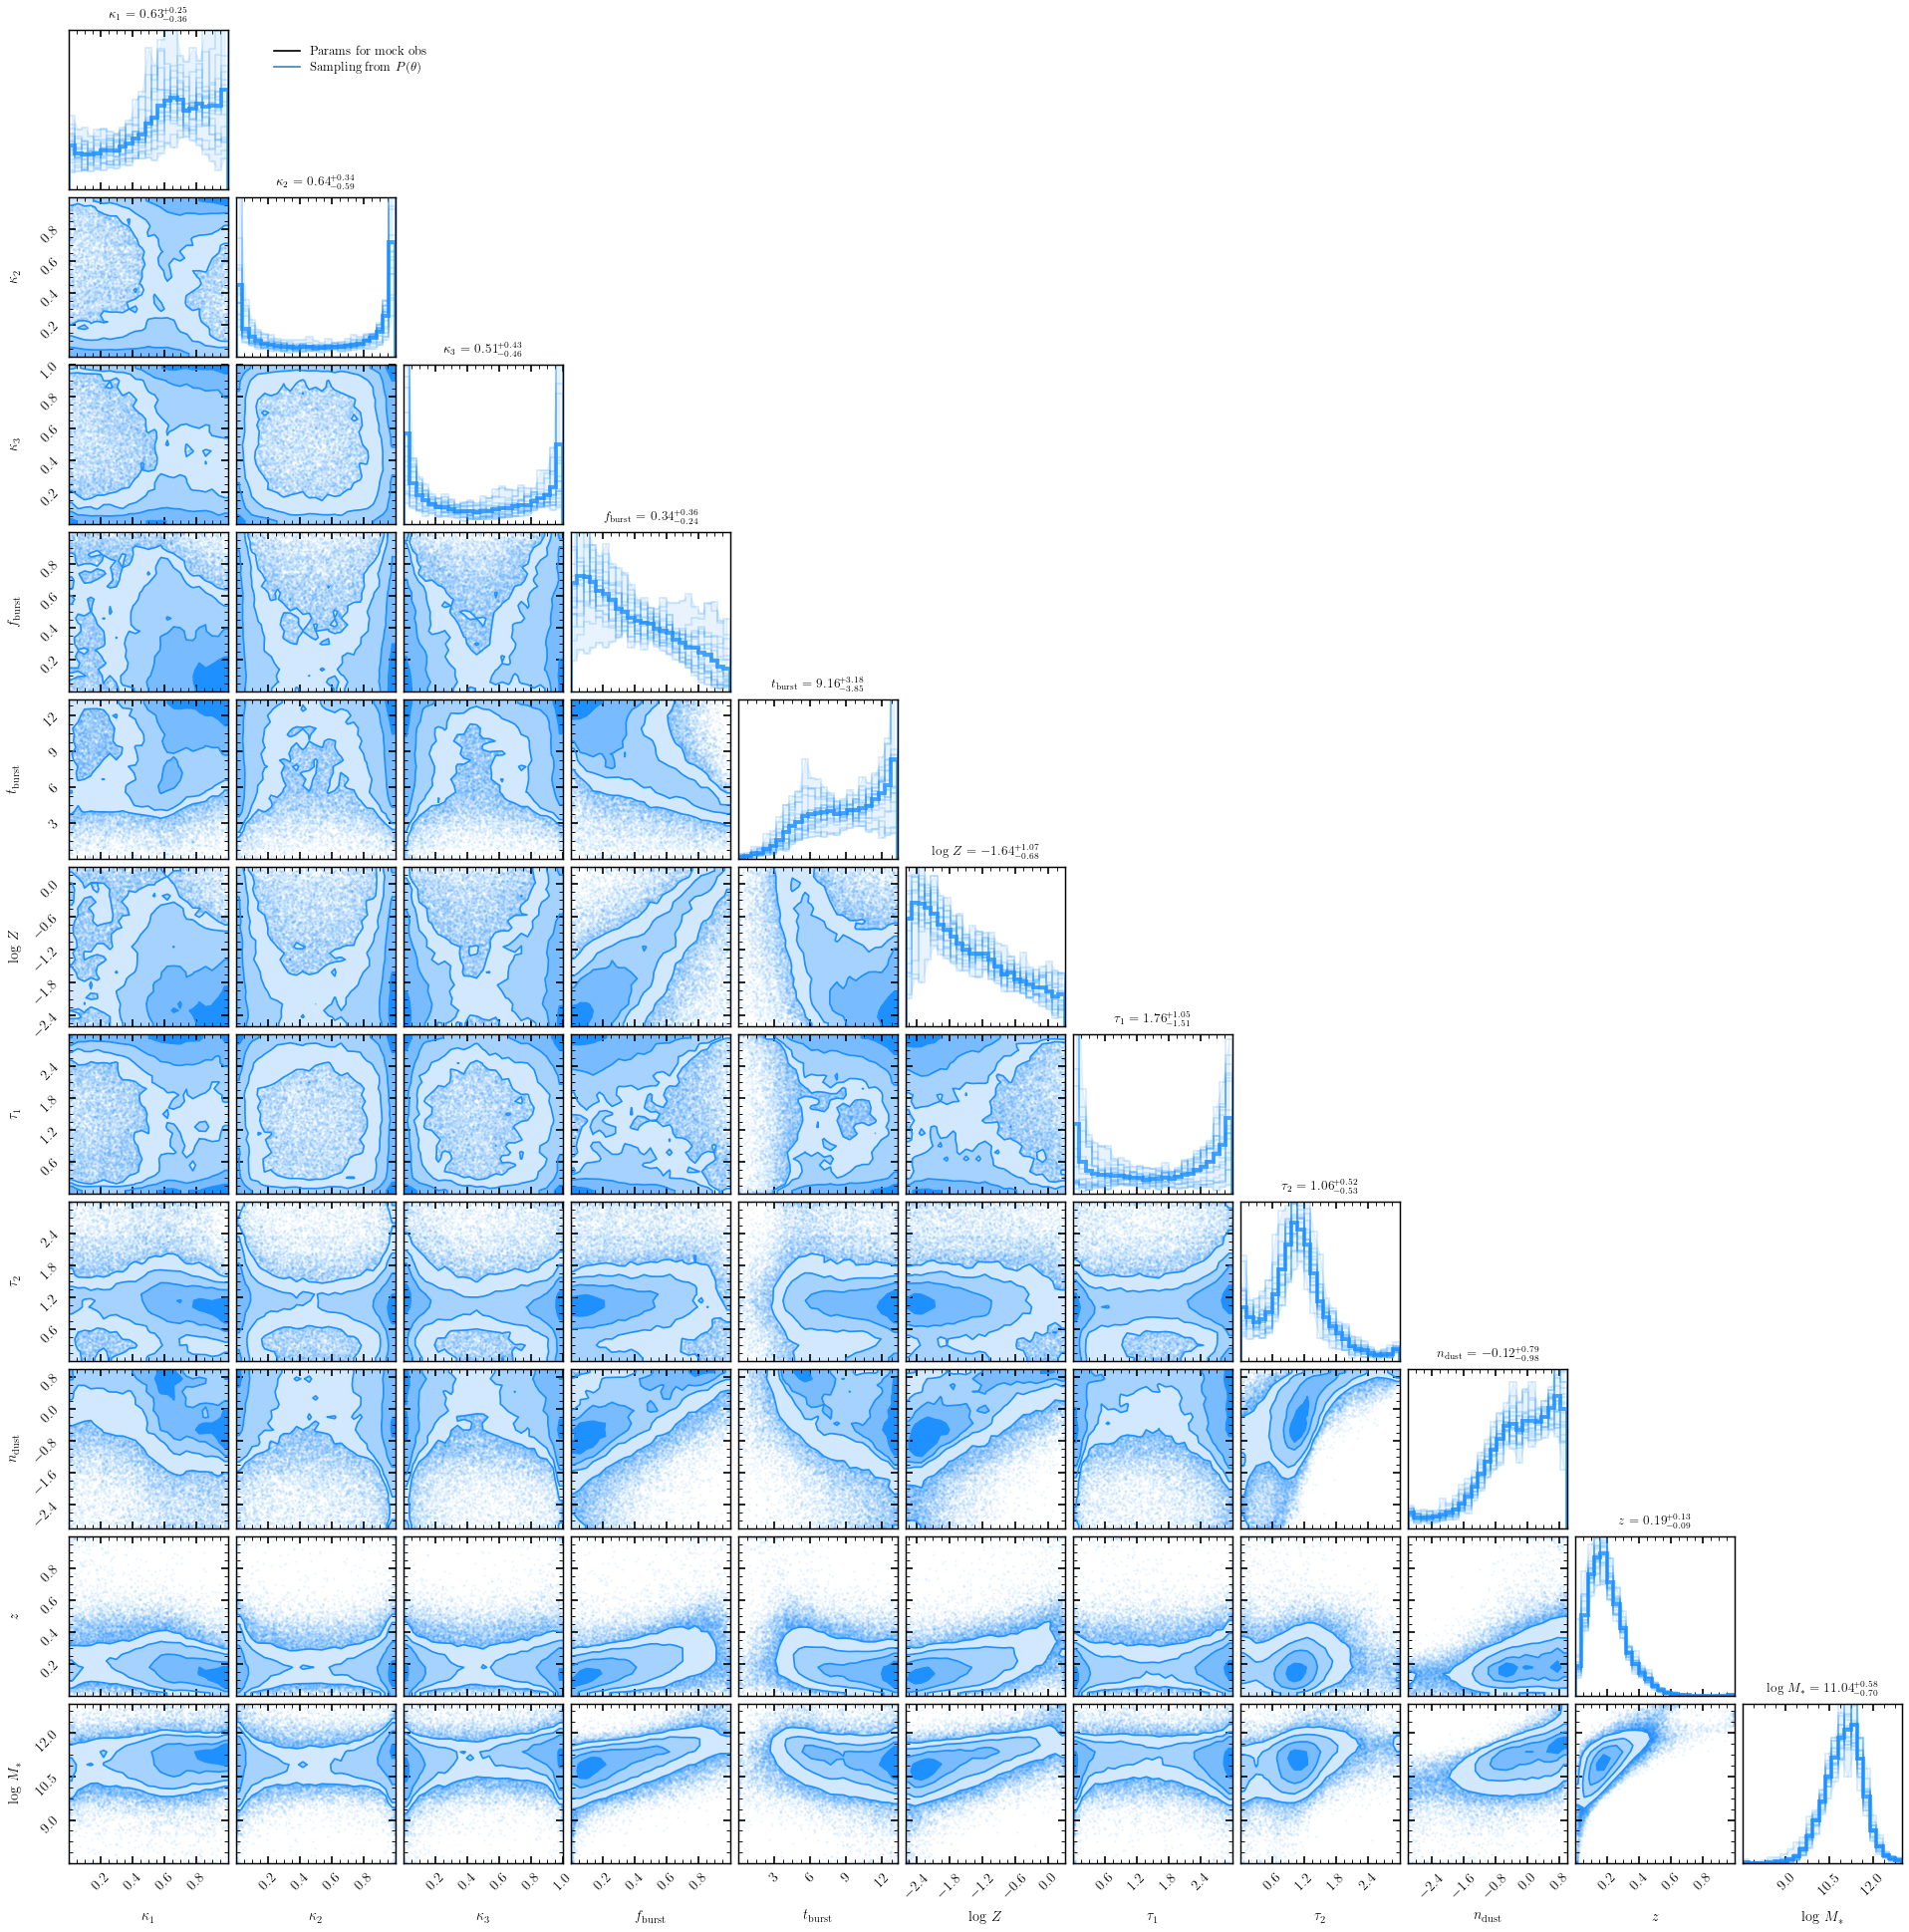

In [58]:
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Params for mock obs')
b_line = mlines.Line2D([], [], color='steelblue', label=r'Sampling from $P(\theta)$')

labels = [
    r'$\kappa_{1}$',
    r'$\kappa_{2}$',
    r'$\kappa_{3}$',
    r'$f_{\mathrm{burst}}$',
    r'$t_{\mathrm{burst}}$',
    r'$\log\,Z$',
    r'$\tau_1$',
    r'$\tau_2$',
    r'$n_{\mathrm{dust}}$',
    r'$z$',
    r'$\log\,M_*$',
    ]

figure = corner.corner(_samples_unt, 
                  labels=labels, bins=25,
                  color='dodgerblue',
                  smooth=0.5, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True})

ax = figure.get_axes()[1]
ax.legend(handles=[k_line, b_line], fontsize=11.5, bbox_to_anchor=(0., 1.0, 1.3, .0))